In [40]:
%matplotlib notebook
import json
import pandas as pd
import numpy as np
import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import pystan

In [3]:
data = json.load(open('matches.json', 'r'))
print(len(data))

39354


# Bets

In [4]:
bets = {}
for d in data:
    if 'tours' in d and len(d['tours']):
        match_id = d['tours'][0]['hltvId']
        
        if match_id == 2310359:
            break
        
        t1_id = d['tourMatches'][0]['teamId1']
        t2_id = d['tourMatches'][0]['teamId2']
        
        t1_score = d['tourMatches'][0]['team1Score']
        t2_score = d['tourMatches'][0]['team2Score']
        
        t1_bets = d['tourBetEvents'][0]['team1Balance']
        t2_bets = d['tourBetEvents'][0]['team2Balance']
        
        if t1_id == d['playerTeams'][0]['id']:
            t1_hltv_id = d['playerTeams'][0]['hltvId']
            t2_hltv_id = d['playerTeams'][1]['hltvId']
        elif t1_id == d['playerTeams'][1]['id']:
            t1_hltv_id = d['playerTeams'][1]['hltvId']
            t2_hltv_id = d['playerTeams'][0]['hltvId']
        else:
            raise Exception('Chablau')
        
        if t1_bets == 0 and t2_bets == 0:
            continue
        
        bets[str(match_id)] = {
            'match_id': str(match_id),
            'team1_id': str(t1_hltv_id),
            'team2_id': str(t2_hltv_id),
            'team1_bets': str(t1_bets),
            'team2_bets': str(t2_bets),
            'team1_score': str(t1_score),
            'team2_score': str(t2_score),
        }
print(len(bets))

7344


# Matches

In [5]:
months = {
    'Jan' : 1,
    'Feb' : 2,
    'Mar' : 3,
    'Apr' : 4,
    'May' : 5,
    'Jun' : 6,
    'Jul' : 7,
    'Aug' : 8,
    'Sep' : 9, 
    'Oct' : 10,
    'Nov' : 11,
    'Dec' : 12
}
cnt = 0
matches = {d['match_id']: {} for d in data if 'match_id' in d}
for d in data:
    if 'match_id' not in d: continue
    matches[d['match_id']].update(d)
    if 'day' in d:
        matches[d['match_id']]['date'] = d['day']+'/'+str(months[d['month']])+'/'+d['year']

    if d['match_id'] in bets and 'team1_id' in d: 
        if d['team1_id'] == bets[d['match_id']]['team1_id'] and d['team2_id'] == bets[d['match_id']]['team2_id']:
            matches[d['match_id']].update(bets[d['match_id']])
            cnt += 1
print(len(matches), cnt)

13157 7257


In [6]:
for match_id in list(matches.keys()):
    if 'team1_rounds' not in matches[match_id] and 'team1_score' not in matches[match_id]:
        del matches[match_id]
print(len(matches))

13157


## Players

In [7]:
cnt1 = cnt2 = cnt3 = 0
for match_id in list(matches.keys()):
    if 'team1_stats' not in matches[match_id] or 'team2_stats' not in matches[match_id]:
        del matches[match_id]
        cnt1 += 1
    elif len(matches[match_id]['team1_stats']) < 5 or len(matches[match_id]['team2_stats']) < 5:
        del matches[match_id]
        cnt2 += 1
    elif len(matches[match_id]['team1_stats']) > 5 or len(matches[match_id]['team2_stats']) > 5:
        del matches[match_id]
        cnt3 += 1
    else:
        for i, p in enumerate(matches[match_id]['team1_stats'], start=1):
            matches[match_id]['team1_p'+str(i)] = p['player_id']
            matches[match_id]['team1_p'+str(i)+'_name'] = p['player_name']
        for i, p in enumerate(matches[match_id]['team2_stats'], start=1):
            matches[match_id]['team2_p'+str(i)] = p['player_id']
            matches[match_id]['team2_p'+str(i)+'_name'] = p['player_name']

# Cleaning

In [12]:
for k, v in matches.items():
    v.pop('team1_stats', None)
    v.pop('team2_stats', None)
    v.pop('match_page', None)
    v.pop('bets_page', None)
    v.pop('year', None)
    v.pop('day', None)
    v.pop('month', None)

df = pd.DataFrame.from_dict(matches, orient='index')
df.date = pd.to_datetime(df.date)
df = df[df.date > pd.to_datetime('2015-01-01')]
df = df[df.team1_rounds != df.team2_rounds]
df['team1_win'] = df.team1_rounds > df.team2_rounds

players_cols = ['team{}_p{}'.format(t, p) for t in [1, 2] for p in [1, 2, 3, 4, 5]]
players = pd.concat([df[c] for c in players_cols])
players = players.value_counts()
players = list(players[players >= 50].index)

df = df[df.team1_p1.isin(players) 
        & df.team1_p2.isin(players)
        & df.team1_p3.isin(players)
        & df.team1_p4.isin(players)
        & df.team1_p5.isin(players)
        & df.team2_p1.isin(players)
        & df.team2_p2.isin(players)
        & df.team2_p3.isin(players)
        & df.team2_p4.isin(players)
        & df.team2_p5.isin(players)]
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
df_train = df[:int(len(df)*0.8)].copy()
df_test = df[int(len(df)*0.8):].copy()
len(df), len(df_train), len(df_test)

(3630, 2904, 726)

# Model

In [14]:
code = '''
data {
    int n_players;
    
    int n;
    int matches[n, 10];
    int team1_win[n];
}
parameters {
    real skill[n_players];
    real<lower=0> alpha;
}
model {
    real s1;
    real s2;
    alpha ~ normal(0, 2.5);
    skill ~ normal(0, 1);
    for(i in 1:n){
        s1 = 0;
        s2 = 0;
        for(j in 1:5){
            s1 = s1 + skill[matches[i, j]];
            s2 = s2 + skill[matches[i, j+5]];
        }
        team1_win[i] ~ bernoulli_logit((s1 - s2)*alpha);
    }
}
'''

# Bradley-Terry model: http://opisthokonta.net/?p=1589
# code = '''
# data {
#     int n;
#     int n_players;
#     int match_players[n, 10];
#     int team1_win[n];
# }
# parameters {
#     simplex[n_players] skill;
# }
# model {
#     real s1;
#     real s2;
#     vector[n_players] alpha;
#     for(i in 1:n_players){
#         alpha[i] = 0.5;
#     }
    
#     skill ~ dirichlet(alpha);
    
#     for(i in 1:n){
#         s1 = 0;
#         s2 = 0;
#         for(j in 1:5){
#             s1 = s1 + skill[match_players[i, j]];
#             s2 = s2 + skill[match_players[i, j+5]];
#         }
#         team1_win[i] ~ bernoulli(s1/(s1 + s2));
#     }
# }
# '''

players = pd.concat([df[c] for c in players_cols])
players = list(players.value_counts().index)
cols = players_cols + ['team1_win']
for c in players_cols:
    df[c] = df[c].apply(lambda x: players.index(x))

df_train = df[:int(len(df)*0.8)].copy()
df_test = df[int(len(df)*0.8):].copy()
    
data = {
    'n_players': len(players),
    
    'n': len(df_train),
    'matches': df_train[players_cols].values + 1,
    'team1_win': df_train['team1_win'].values.astype('int32'),
}
fit = pystan.stan(model_code=code, data=data, iter=10000, chains=4, n_jobs=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9111c342238dc70f8cbd57c61516c79e NOW.


<IPython.core.display.Javascript object>


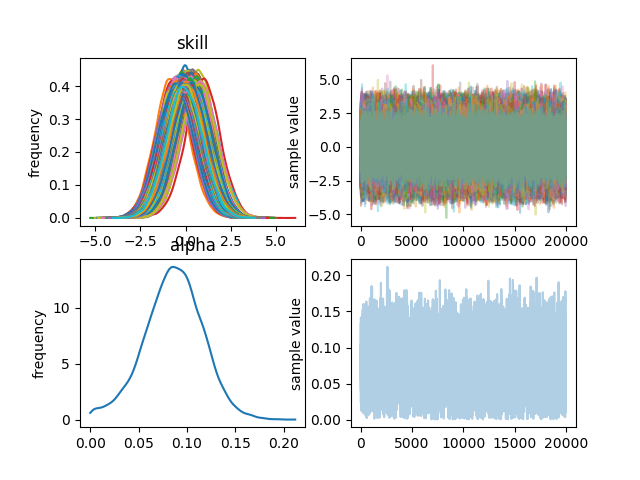

In [15]:
fit.plot();

In [16]:
trace = fit.extract()

Inference for Stan model: anon_model_75926c64b9aab05653baef633e58d25d.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
skill[0]              0.27  6.6e-3   0.94  -1.58  -0.36   0.27    0.9   2.09  20000    1.0
skill[1]             -0.17  6.7e-3   0.94  -2.02   -0.8  -0.17   0.46   1.69  20000    1.0
skill[2]              0.06  6.8e-3   0.96  -1.83  -0.59   0.06   0.71   1.91  20000    1.0
skill[3]              0.04  6.8e-3   0.96  -1.83  -0.61   0.04    0.7   1.92  20000    1.0
skill[4]            9.3e-3  6.8e-3   0.96  -1.85  -0.64   0.02   0.66   1.87  20000    1.0
skill[5]              0.06  6.7e-3   0.94  -1.82  -0.58   0.07    0.7   1.89  20000    1.0
skill[6]              0.07  6.8e-3   0.96  -1.84  -0.57   0.07   0.72   1.95  20000    1.0
skill[7]              0.24  6.6e-3   0.94  -1.64  -0.39   0.23   0.87   2.06  200

In [17]:
skill = trace['skill']

In [38]:
pids = df_train[players_cols].values
y = df_train.team1_win.values

y_pred = []
for i in range(pids.shape[0]):
    s1 = skill[:, pids[i, :5]].mean(axis=0).sum()
    s2 = skill[:, pids[i, 5:]].mean(axis=0).sum()
    y_pred.append(s1 > s2)
y_pred = np.array(y_pred)

(y_pred == y).mean()

0.58780991735537191

In [39]:
pids = df_test[players_cols].values
y = df_test.team1_win.values

y_pred = []
for i in range(pids.shape[0]):
    s1 = skill[:, pids[i, :5]].mean(axis=0).sum()
    s2 = skill[:, pids[i, 5:]].mean(axis=0).sum()
    y_pred.append(sta s1 > s2)
y_pred = np.array(y_pred)

(y_pred == y).mean()

0.50826446280991733

In [ ]:
sm.b

In [11]:
pred = trace['team1_win_pred']

In [12]:
true = df_test.team1_win.values

In [13]:
true.mean()

0.52819548872180455

In [17]:
ha = (pred.mean(axis=0) <= 0.5)

In [15]:
(ha == true).mean()

0.50187969924812026

In [16]:
skill = trace['skill']

skill_mean = skill.mean(axis=0)

p1 = pd.concat([df[c] for c in players_cols])
p2 = pd.concat([df[c+'_name'] for c in players_cols])
ranking = pd.concat([p1, p2], axis=1).drop_duplicates()
ranking.columns = ['player_id', 'player_name']

ranking['skill'] = ranking.player_id.apply(lambda x: skill_mean[x])
pd.set_option('display.max_rows', 500)
ranking.sort_values('skill', ascending=False).reset_index()

index  player_id                             player_name     skill
0      112         43                  Danylo 'Zeus' Teslenko  0.712648
1       57         42                Fernando 'fer' Alvarenga  0.494223
2      237         62                   Ricardo 'boltz' Prass  0.461401
3      115         40                   Dennis 'dennis' Edman  0.447300
4      764         61                       Lincoln 'fnx' Lau  0.445056
5       37          8                  Fabien 'kioShiMa' Fiey  0.443768
6       65         10                Robin 'flusha' Rönnquist  0.441463
7      188         35                 Adil 'ScreaM' Benrlitom  0.435531
8        2         25                Freddy 'KRIMZ' Johansson  0.431209
9       33         11                    Jesper 'JW' Wecksell  0.426064
10     109         39                 Gabriel 'FalleN' Toledo  0.373538
11    1352         81                     Martin 'STYKO' Styk  0.368039
12      43         46                 Kirill 'ANGE1' Karasiow  0.358906
13      73         63               Ruben 'RUBINO' Villarroel  0.347414
14     932         89                     Patrik 'Zero' Žúdel  0.343361
15      66        174                  Simeon 'dream3r' Ganev  0.331524
16      79         23                 Mathias 'MSL' Lauridsen  0.324649
17     591         47                Marcelo 'coldzera' David  0.321201
18    1341         79                     Lucas 'lucas' Teles  0.311228
19     928         66                  Andreas 'MODDII' Fridh  0.308962
20     207         78                   Henrique 'hen1' Teles  0.306024
21    1819        165                   Nikolay 'nkl' Krastev  0.304960
22      47         17               Janusz 'Snax' Pogorzelski  0.297224
23      52         14                 Paweł 'byali' Bieliński  0.291926
24     545        164           Emiliyan 'spyleadeR' Dimitrov  0.284000
25     135         13                     Wiktor 'TaZ' Wojtas  0.282391
26      56         16                      Filip 'NEO' Kubski  0.281912
27     645        130                   Tomáš 'oskar' Šťastný  0.278322
28      41         15     Jarosław 'pashaBiceps' Jarząbkowski  0.277535
29    1303        101           Valdemar 'valde' Bjørn Vangså  0.274289
30    1887        162             Denis 'electronic' Sharipov  0.267278
31      29          0                      René 'cajunb' Borg  0.265236
32     686        116                     Lucas 'steel' Lopes  0.261745
33     997        114                Ryan 'freakazoid' Abadir  0.260014
34     933         73                Lukas 'gla1ve' Rossander  0.258766
35    2721        190                  Abay 'HObbit' Khasenov  0.247864
36    1140        136             Bradley 'android-x23' Fodor  0.245640
37     434        113                 Mikail 'Maikelele' Bill  0.237515
38      89          7                 Richard 'shox' Papillon  0.235625
39     687         53                 Epitacio 'TACO' de Melo  0.221536
40     927        124                 William 'draken' Sundin  0.219177
41      40         22                  Adam 'friberg' Friberg  0.214944
42     123         27           Edouard 'SmithZz' Dubourdeaux  0.212986
43    1200        184                  André 'BARBARR' Möller  0.209907
44     106         45         Vladyslav 'bondik' Nechyporchuk  0.202646
45       8         20                Richard 'Xizt' Landström  0.198436
46     210         54              Yegor 'markeloff' Markelov  0.198021
47    1725        139                       Kia 'Surreal' Man  0.197212
48      12         51                     Tarik 'tarik' Celik  0.194913
49       4        100                  Sean 'seang@res' Gares  0.194671
50     832        195                  David 'DAVEY' Stafford  0.192724
51      17         38              Kristian 'k0nfig' Wienecke  0.188470
52     937        135                    Rory 'dephh' Jackson  0.184870
53     876         50                      Emil 'Magisk' Reif  0.181704
54      20         26                     Ale

In [ ]:
skil